\noindent __Erwann Rault__  
_Centre Oscar Lambret (Lille)_

In [2]:
# DRAW MATPLOTLIB IN NOTEBOOK #

%matplotlib inline
# %matplotlib notebook


In [3]:
# LIBRARIES #

import numpy as np
import dicom as dcm
import matplotlib.pyplot as plt
import math
import time
import datetime

from scipy import ndimage
from ipywidgets import *

from openpyxl import load_workbook
from openpyxl.styles import Font, Color, colors

from IPython import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from os.path import basename

import warnings
warnings.filterwarnings('ignore')


In [40]:
# INPUT VARIABLES #

# Dicom files:
filepath = 'X:/Med Nuc/CQ TEP-CT/CQ SUV/CQ 2017.03.22/PET AC'

# Results written to:
EXCEL_FILE ='X:/Med Nuc/CQ TEP-CT/CQ TEP-CT.xlsx'
EXCEL_SHEET = 'CQ SUV'

# Injected activity:
isotopeName = "F18"
T1demi = 1.8295 # hours, half life from the isotope

Ainj = 24.5 #MBq
Tinj = datetime.datetime(2017,3,22,16,38)

Ares = 0.05 #MBq
Tres = datetime.datetime(2017,3,22,16,44)

# CSTES #
margeROI = -7 #pix
thresholdPhantom = 0.7

In [41]:
# PARSE ALL DICOM FILES IN THE DIRECTORY #

# Get the file list
listFilesDCM = []  # creates an empty list
for dirName, subdirList, fileList in os.walk(filepath):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            listFilesDCM.append(os.path.join(dirName,filename))
            
            
# essayer avec series instance UID:
seriesDescr = ''
nbslices = 0
nbimgs = 0
listImgs = []
listmp = []
for filenameDCM in listFilesDCM:
    ds = dcm.read_file(filenameDCM)
    if (seriesDescr != ds[0x0008,0x103E].value):
        if (seriesDescr != ''):
            listmp.append(nbslices)
            listImgs.append(listmp)
            listmp = []
        nbimgs = nbimgs + 1
        seriesDescr = ds[0x0008,0x103E].value
        nbslices = 1
        listmp.append(seriesDescr)
        listmp.append(ds.Rows)
        listmp.append(ds.Columns)
    else:
        nbslices = nbslices + 1
listmp.append(nbslices)
listImgs.append(listmp)

In [42]:
# SERIE TO READ #

imgToRead = 1 # nb of the image to read

# Acquisition information

In [43]:
# READS THE DICOM FILE #

# Dimensions:
seriesDescr = listImgs[imgToRead-1][0]
nb_pixel_x = listImgs[imgToRead-1][1]
nb_pixel_y = listImgs[imgToRead-1][2]
nb_slices = listImgs[imgToRead-1][3]
constPixDim = (nb_slices, nb_pixel_y, nb_pixel_x)
pixArray = np.zeros(constPixDim, dtype=np.float32)

# loop through all the DICOM files
for filenameDCM in listFilesDCM:
    dstmp = dcm.read_file(filenameDCM)
    if (seriesDescr == dstmp[0x0008,0x103E].value):
        try:
            rescaleIntercept = dstmp[0x0028,0x1052].value
            rescaleSlope = dstmp[0x0028,0x1053].value
        except KeyError:
            rescaleIntercept = 0
            rescaleSlope = 1
        pixArray[listFilesDCM.index(filenameDCM),:,:] = dstmp.pixel_array.astype(np.float32) * rescaleSlope + rescaleIntercept



In [44]:
# CONVERT DICOM TIME INFO TO DATETIME #

def convertToDatetime(date, time):
    year = int(int(date)/10000)
    month = int(int(date)/100-year*100)
    day = int(int(date)-year*10000-month*100)
    hour = int(float(time)/10000)
    minute = int(float(time)/100-hour*100)
    seconds =  int(float(time)-minute*100-hour*10000)
    return datetime.datetime(year, month, day, hour, minute, seconds)

In [45]:
# GET RELEVANT INFORMATION FROM DICOM FILE #

patient_name = ds.PatientName

study_date = ds.StudyDate
scan_time = ds[0x0008,0x0032].value
acq_datetime = convertToDatetime(study_date,scan_time)

recons_corrections = ds[0x0028,0x0051].value
frame_duration = ds[0x0018,0x1242].value / 1000 #in ms
phantomVolume = ds[0x0054,0x0016][0][0x0018,0x1071].value

print "Patient name: ", patient_name
print "Patient ID: ", ds[0x0020,0x0010].value
print "File path:", filepath
print " "
print "Injected Isotope: ", isotopeName, "(half life:", T1demi,"h)"
print "Radiopharmaceutical: ", ds[0x0054,0x0016][0][0x0018,0x0031].value
print "Injected activity: ", Ainj, " MBq @ ", Tinj
print "Residual activity: ", Ares, " MBq @ ", Tres
print "Radionuclide volume", phantomVolume, "mL"
print " "
print "Scan date and time: ", acq_datetime
print "Scan duration: ", frame_duration, "s"
print "Image size: {0} x {1} x {2}" .\
                format(constPixDim[2], constPixDim[1], constPixDim[0])
print "Energy window: ", ds[0x0054,0x0013][0][0x0054,0x0014].value, "to", ds[0x0054,0x0013][0][0x0054,0x0015].value, "keV"
print "Image units:", ds[0x0054,0x1001].value
print "Reconstruction corrections:", recons_corrections
print "Scatter correction method:", ds[0x0054,0x1105].value
print "Dose calibration factor:", ds[0x0054,0x1322].value
print "Scatter fraction factor:", ds[0x0054,0x1323].value
print "Dead time factor:", ds[0x0054,0x1324].value
print "Rescale slope:", rescaleSlope
print "Rescale intercept:", rescaleIntercept
print " "
print "TEP system: ", ds[0x0008,0x0070].value
print "            ", ds[0x0008,0x1010].value


Patient name:  zzzSUV_CalCheck
Patient ID:  15805
File path: X:/Med Nuc/CQ TEP-CT/CQ SUV/CQ 2017.03.22/PET AC
 
Injected Isotope:  F18 (half life: 1.8295 h)
Radiopharmaceutical:  FDG -- fluorodeoxyglucose
Injected activity:  24.5  MBq @  2017-03-22 16:38:00
Residual activity:  0.05  MBq @  2017-03-22 16:44:00
Radionuclide volume 5640 mL
 
Scan date and time:  2017-03-22 17:34:47
Scan duration:  120 s
Image size: 256 x 256 x 83
Energy window:  425 to 650 keV
Image units: BQML
Reconstruction corrections: ['DECY', 'ATTN', 'SCAT', 'DTIM', 'RANSNG', 'DCAL', 'SLSENS', 'NORM']
Scatter correction method: Model Based
Dose calibration factor: 33176
Scatter fraction factor: 0.292832
Dead time factor: 1.01716
Rescale slope: 0.00684006
Rescale intercept: 0
 
TEP system:  GE MEDICAL SYSTEMS
             D690


# SUV calibration factor

In [46]:
# LAYOUT DEFINITIONS #

box_layout_std = Layout(display='flex',
                    flex_flow='row wrap',
                    justify_content='flex-start',
                    width='100%')

box_layout_right = Layout(display='flex',
                    flex_flow='row wrap',
                    justify_content='flex-end',
                    border='solid 0.5px #EEE',
                    width='100%')


In [47]:
# FINDS THE SUV PHANTOM IN THE IMAGE #

# function to find the phantom dimension and center in the image
def findPhantom(img, dimx, dimy, dimz, tp):
    com = ndimage.measurements.center_of_mass(img)
    #com = ndimage.measurements.maximum_position(img)

    maxx = ndimage.measurements.maximum(img[com[0],com[1],:])
    x1 = 0
    while (img[com[0],com[1],x1]<maxx*tp):
        x1 = x1+1
    x2 = dimx-1
    while (img[com[0],com[1],x2]<maxx*tp):
        x2 = x2-1
    x1=x1-1
    x2=x2+1
    
    maxy = ndimage.measurements.maximum(img[com[0],:,com[2]])
    y1 = 0
    while (img[com[0],y1,com[2]]<maxy*tp):
        y1 = y1+1
    y2 = dimy-1
    while (img[com[0],y2,com[2]]<maxy*tp):
        y2 = y2-1
    y1=y1-1
    y2=y2+1

    maxz = ndimage.measurements.maximum(img[:,com[1],com[2]])
    z1 = 0
    while (img[z1,com[1],com[2]]<maxz*tp):
        z1 = z1+1
    z2 = dimz-1
    while (img[z2,com[1],com[2]]<maxz*tp):
        z2 = z2-1
    z1=z1-1
    z2=z2+1
    
    centerx = int(x1+(x2-x1)/2)
    centery = int(y1+(y2-y1)/2)
    centerz = int(z1+(z2-z1)/2)
    
    if ((y2-y1)>(x2-1)):
        radius =(y2-y1)/2
    else:
        radius = (x2-x1)/2
    length = z2-z1

    return [centerx, centery, centerz, radius, length]


In [48]:
# FUNCTION TO GET THE STATS INSIDE THE VOI #

def get_stats(img, dimx, dimy, dimz, centerx, centery, centerz, r, h):
    l = []
    for k in range(int(centerz-h/2), int(centerz+h/2)):
        for j in range(0, dimy):
            for i in range(0, dimx):
                if (math.sqrt((i-centerx)*(i-centerx)+(j-centery)*(j-centery))<=r):
                    l.append(img[k,j,i])
                    #m_img[k,j,i] = 0

    return np.amin(l), np.amax(l), np.mean(l), np.std(l)

In [49]:
# FUNCTION TO DISPLAY CALC RESULTS #
    
def dispResults(pxls, dim, roi, marge, tacq):
    """
    Disp the results:
      pxls - pixel array of the images
      dim - dimension of the pixel array (dim[2]:x dim[1]:y dim[0]: nb of images)
      roi - ROI where the mean activity is calculated
      marge - margin applied to the auto-segmented roi
      tacq - acquisition date and time
    Return:
      Array of calculated values (activity conc. in the phantom, min, max and mean measured activities, std. dev. of 
          activity inside the phantom)
    """
    mini, maxi, mean, std = get_stats(pxls, dim[2], dim[1], dim[0] ,roi[0], 
                         roi[1], roi[2], roi[3]+marge, roi[4]+(2*marge))

    t = (tacq - Tinj).total_seconds()/3600.0
    A = Ainj * math.exp(-t*math.log(2)/T1demi)
    t = (tacq - Tres).total_seconds()/3600.0
    B = Ares * math.exp(-t*math.log(2)/T1demi)
    Aph = (A-B)/phantomVolume*1000000
    error = (mean-Aph)/Aph*100
    
    print 'Injected activity in the phantom: ', round(Aph,0), 'Bq/ml'
    print '   ' 
    print 'Measured values in the VOI:'
    print '  - min. activity: ', round(mini, 2), 'Bq/ml'
    print '  - max. activity: ', round(maxi, 2), 'Bq/ml'
    print '  - mean activity: ', round(mean, 2), 'Bq/ml'
    print '  - std deviation: ', round(std, 2), 'Bq/ml (', round(std/mean*100,2),'%)'
    print '   ' 
    if (abs(error)<10):
        print '  >>> Test succeeded! (error', round(error,2), '%)'
    else:
        print '  >>> Important discrepancies! (error', round(error,2), '%)'
        print '  >>> Calibration factor must be verified!'
    print '   ' 
    print '   ' 

    r = [Aph, mini, maxi, mean, std, error]
    
    return r
    


In [50]:
# FUNCTION TO WRITE RESULTS IN EXCEL FILE #
    
def saveToXls(r, tacq):    
    """
    Write results in an excel file
      results - array of main results to write to the excel file
      tacq - acquisition date and time
    Return:
      void
    """
    
    wb = load_workbook(EXCEL_FILE)
    sheet = wb.get_sheet_by_name(EXCEL_SHEET)

    maxrow = 5
    while (sheet['A'+str(maxrow)].value != None):
        maxrow = maxrow+1
    
    sheet['A'+str(maxrow)] = tacq
    sheet['C'+str(maxrow)] = Ainj
    sheet['D'+str(maxrow)] = float(r[0])
    sheet['F'+str(maxrow)] = float(r[1])
    sheet['G'+str(maxrow)] = float(r[2])
    sheet['H'+str(maxrow)] = float(r[3])
    sheet['I'+str(maxrow)] = float(r[4])
    sheet['J'+str(maxrow)] = float(r[4]/r[3]*100)
    sheet['L'+str(maxrow)] = float(r[5])

    ft = Font(color=colors.RED, bold = True)
    if ((r[5]>10)and(r[5]<-10)):
        sheet['L'+str(maxrow)].font = ft

    wb.save(EXCEL_FILE)


Injected activity in the phantom:  3029.0 Bq/ml
   
Measured values in the VOI:
  - min. activity:  1904.03 Bq/ml
  - max. activity:  4605.93 Bq/ml
  - mean activity:  2996.83 Bq/ml
  - std deviation:  293.89 Bq/ml ( 9.81 %)
   
  >>> Test succeeded! (error -1.05 %)
   
   


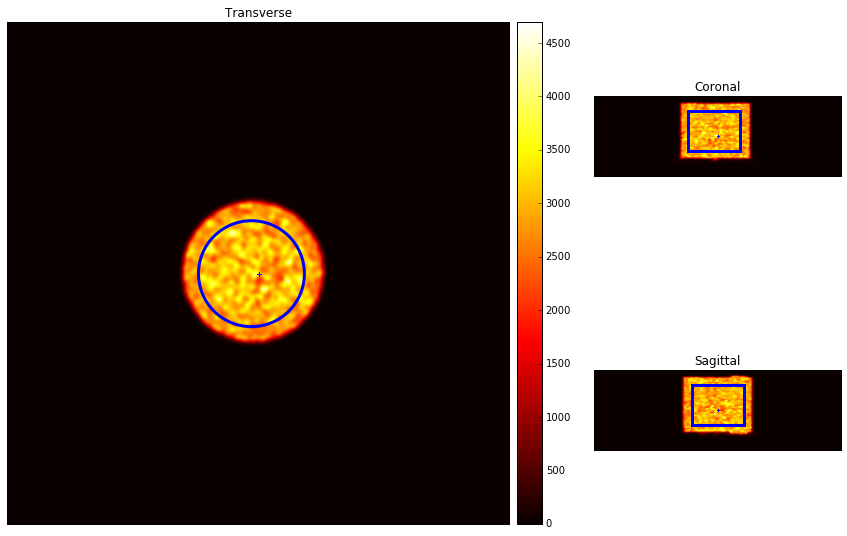

In [51]:
# MAIN INTERFACE #

# Draws circle centers
def redrawCenters():
    line1a[0].set_xdata([xslider.value-1,xslider.value+1])
    line1a[0].set_ydata([zslider.value,zslider.value])
    line1b[0].set_xdata([xslider.value,xslider.value])
    line1b[0].set_ydata([zslider.value-1,zslider.value+1])
    line2a[0].set_xdata([yslider.value-1,yslider.value+1])
    line2a[0].set_ydata([zslider.value,zslider.value])
    line2b[0].set_xdata([yslider.value,yslider.value])
    line2b[0].set_ydata([zslider.value-1,zslider.value+1])
    line3a[0].set_xdata([xslider.value-1,xslider.value+1])
    line3a[0].set_ydata([yslider.value,yslider.value])
    line3b[0].set_xdata([xslider.value,xslider.value])
    line3b[0].set_ydata([yslider.value-1,yslider.value+1])
        
def refreshPlot(b):    
    minv = minslider.value
    maxv = maxslider.value
    if (minv>maxv):
        print "Erreur: min > max"
    else:
        im1.set_data(pixArray[:,yslider.value,:])
        im1.set_clim(vmin=minv, vmax=maxv)
        im2.set_data(pixArray[:,:,xslider.value])
        im2.set_clim(vmin=minv, vmax=maxv)
        im3.set_data(pixArray[zslider.value,:,:])
        im3.set_clim(vmin=minv, vmax=maxv)
    redrawCenters()
    display.clear_output(wait=True)
    display.display(fig)
    results = dispResults(pixArray, dim, roi, margeROI, acq_datetime)
  
def onSaveXlsButtonClicked(b):
    saveToXls(results, acq_datetime)


# Plot size
plt.rcParams['figure.figsize'] = (15,9)

# min, max of main image:
_min, _max = np.amin(pixArray), np.amax(pixArray)

# Ipywidgets:
minslider  = FloatSlider(value=_min, min=_min, max=_max, 
                         step=(_max-_min)/100, description='min', width='40%')
maxslider  = FloatSlider(value=_max, min=_min, max=_max*1.5, 
                         step=(_max-_min)/100, description='max', width='40%')

xslider = IntSlider(value=int(nb_pixel_x/2), min=0, max=nb_pixel_x-1, 
                    step=1, description="x",width='40%')
yslider = IntSlider(value=int(nb_pixel_y/2), min=0, max=nb_pixel_y-1, 
                    step=1, description="y",width='40%')
zslider = IntSlider(value=int(nb_slices/2), min=0, max=nb_slices-1, 
                    step=1, description="z",width='40%')

refresh_button = Button(description="Refresh!", width='30%') #, height='100px'
refresh_button.on_click(refreshPlot)


save_button = Button(description="Save to excel file!", width='25%') #, height='100px'
save_button.on_click(onSaveXlsButtonClicked)

items1 = [
    Label(value="Visualization window:", width='90%'),
    minslider,
    maxslider,
    Label(value=". ", width='90%'),
    Label(value="View slices", width='90%'),
    xslider,
    yslider,
    zslider,
    Label(value=". ", width='90%'),
 ]
items2 = [
    refresh_button,
    save_button,
]

box1 = Box(children=items1, layout=box_layout_std)
box2 = Box(children=items2, layout=box_layout_right)
display.display(box1)
display.display(box2)

# Plots the images:
fig = plt.figure()
gs = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(gs[0,2])
im1 = ax1.imshow(pixArray[:,yslider.value,:], cmap="hot", vmin = _min, vmax = _max)
ax1.set_title('Coronal')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax1.axes.autoscale(False)

ax2 = fig.add_subplot(gs[1,2])
im2 = ax2.imshow(pixArray[:,:,xslider.value], cmap="hot", vmin = _min, vmax = _max)
ax2.set_title('Sagittal')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.axes.autoscale(False)

ax3 = fig.add_subplot(gs[:,:-1])
im3 = ax3.imshow(pixArray[zslider.value,:,:], cmap="hot", vmin = _min, vmax = _max)
ax3.set_title('Transverse')
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
ax3.axes.autoscale(False)

roi = findPhantom(pixArray, nb_pixel_x, nb_pixel_y, nb_slices, thresholdPhantom)

try:
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im3, cax=cax3)
    line1a = ax1.axes.plot([xslider.value-1,xslider.value+1], 
                  [zslider.value,zslider.value], 
                  color='blue', linestyle='-', linewidth=1)
    line1b = ax1.axes.plot([xslider.value,xslider.value], 
                  [zslider.value-1,zslider.value+1], 
                  color='blue', linestyle='-', linewidth=1)
    line2a = ax2.axes.plot([yslider.value-1,yslider.value+1], 
                  [zslider.value,zslider.value], 
                  color='blue', linestyle='-', linewidth=1)
    line2b = ax2.axes.plot([yslider.value,yslider.value], 
                  [zslider.value-1,zslider.value+1], 
                  color='blue', linestyle='-', linewidth=1)
    line3a = ax3.axes.plot([xslider.value-1,xslider.value+1], 
                  [yslider.value,yslider.value], 
                  color='blue', linestyle='-', linewidth=1)
    line3b = ax3.axes.plot([xslider.value,xslider.value], 
                  [yslider.value-1,yslider.value+1], 
                  color='blue', linestyle='-', linewidth=1)
    c1 = plt.Circle((roi[0], roi[1]), roi[3]+margeROI, fill=False, 
                      color='blue', linewidth=3)
    ax3.axes.add_patch(c1)
    r1 = plt.Rectangle((roi[0]-roi[3]-margeROI, roi[2]-roi[4]/2-margeROI), 
                      (roi[3]+margeROI)*2, roi[4]+2*margeROI, fill=False, 
                      color='blue', linewidth=3)
    ax1.axes.add_patch(r1)
    r2 = plt.Rectangle((roi[1]-roi[3]-margeROI, roi[2]-roi[4]/2-margeROI), 
                      (roi[3]+margeROI)*2, roi[4]+2*margeROI, fill=False, 
                      color='blue', linewidth=3)
    ax2.axes.add_patch(r2)
except Error: 
    print 'Error!'

dim = [nb_slices ,nb_pixel_y, nb_pixel_x]
results = dispResults(pixArray, dim, roi, margeROI, acq_datetime)




# Remarks:

